In [16]:
import os
import pandas as pd
os.getcwd()


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import TargetEncoder, LabelEncoder

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import time
import pickle
from xgboost import XGBClassifier

import pandas as pd
import time
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

NUMERIC_COLS = [
    "TP_FAIXA_ETARIA",
    "TP_ESTADO_CIVIL",
    "TP_COR_RACA",
    "TP_NACIONALIDADE",
    "TP_ST_CONCLUSAO",
    "TP_ANO_CONCLUIU",
    "IN_TREINEIRO",
    "CO_MUNICIPIO_PROVA",
    "CO_UF_PROVA",
    "TP_PRESENCA_CN",
    "TP_PRESENCA_CH",
    "TP_PRESENCA_LC",
    "TP_PRESENCA_MT",
    "NU_NOTA_CN",
    "NU_NOTA_CH",
    "NU_NOTA_LC",
    "NU_NOTA_MT",
    "TP_LINGUA",
    "NU_NOTA_REDACAO",
    "NU_NOTA_COMP1",
    "NU_NOTA_COMP2",
    "NU_NOTA_COMP3",
    "NU_NOTA_COMP4",
    "NU_NOTA_COMP5",
    "TP_ESCOLA"
]

CATEGORICAL_COLS = [
    "TP_SEXO",
    "Q001",
    "Q002",
    "Q003",
    "Q004",faixa_renda_familiar
    "Q012",
    "Q013",
    "Q014",
    "Q015",
    "Q016",
    "Q017",
    "Q018",
    "Q019",
    "Q020",
    "Q021",
    "Q022",
    "Q023",
    "Q024",
    "Q025",
    "NO_MUNICIPIO_PROVA",
    "TP_STATUS_REDACAO",
    "SG_UF_PROVA"
]


def generate_pipeline():
    numeric_transformer = Pipeline(steps=[("scaler", MinMaxScaler())])

    categorical_transformer = Pipeline(steps=[("encoder", OrdinalEncoder())])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, NUMERIC_COLS),
            ("cat", categorical_transformer, CATEGORICAL_COLS),
        ]
    )

    return Pipeline(steps=[("preprocessor", preprocessor)])


In [2]:
df_microdados = pd.read_parquet('../../tcc-results/data-results/data_prepared_enem_2022.parquet')

In [3]:
df_microdados.shape 

(3476105, 54)

In [4]:
df_microdados['faixa_renda_familiar']

0          B
1          Q
2          B
3          A
4          B
          ..
3476100    F
3476101    B
3476102    G
3476103    E
3476104    B
Name: faixa_renda_familiar, Length: 3476105, dtype: object

In [5]:
map_renda = {
    "A": ["P", "Q"], # 15 A 25 SALÁRIOS
    "B": ["N", "O"], # 10 A 15 SALÁRIOS
    "C": ["J", "K", "L", "M"], # 5 A 10 SALÁRIOS
    "D": ["E", "F", "G", "H", "I"], # 2 A 5 SALÁRIOS
    "E":  ["A", "B", "C"], # ATÉ 2 SALÁRIOS
}

In [6]:
# Função para fazer o mapeamento inverso
def map_values(value, mapping):
    for key, values in mapping.items():
        if value in values:
            return key
    return value

In [7]:
# Aplicar a função de mapeamento na coluna do DataFrame
df_microdados['faixa_renda_familiar'] = df_microdados['faixa_renda_familiar'].apply(map_values, mapping=map_renda)

In [8]:
df_microdados['faixa_renda_familiar'].value_counts()

faixa_renda_familiar
E    1811622
D    1311047
C     193806
A      85772
B      73858
Name: count, dtype: int64

In [9]:
df_microdados['faixa_renda_familiar'].head(5)

0    E
1    A
2    E
3    E
4    E
Name: faixa_renda_familiar, dtype: object

In [10]:
df_microdados['faixa_renda_familiar'].head(5)

0    E
1    A
2    E
3    E
4    E
Name: faixa_renda_familiar, dtype: object

In [11]:
def encode_target(y):
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    return y_encoded, encoder

In [12]:
X = df_microdados.drop('faixa_renda_familiar', axis=1)
y = df_microdados['faixa_renda_familiar']
y_encoded, encoder = encode_target(y)

In [13]:
# unique valus from np.array
np.unique(y_encoded)

array([0, 1, 2, 3, 4])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [15]:
model = XGBClassifier(n_estimators=400, objective = 'multi:softmax', num_class = 5, eval_metric='logloss', n_jobs=-1)

k_folds = 5

pipe = generate_pipeline()
            
X_train_method = pipe.fit_transform(X_train)
X_test_transformed = pipe.transform(X_test)

kf = KFold(n_splits=k_folds, shuffle=True)
cv_results = cross_val_score(model, X_train_method, y_train, cv=kf)

# get training time
start_time = time.time()
model.fit(X_train_method, y_train)
end_time = time.time()

# save model
with open(f'/home/cristiano/ufpr/tcc/multiclasse/baseline/modelos/multiclass_baseline_without_scaler.pkl', 'wb') as file:
    pickle.dump(model, file)

training_time = end_time - start_time
print("Tempo de treinamento:", training_time)

y_predicted = model.predict(X_test_transformed)

# get classification metrics
test_accuracy = accuracy_score(y_test, y_predicted)
test_f1_score = f1_score(y_test, y_predicted, average='weighted')
test_precision = precision_score(y_test, y_predicted, average='weighted')
test_recall = recall_score(y_test, y_predicted, average='weighted')

print("Accuracy médio na validação cruzada:", np.mean(cv_results))
print("Accuracy no conjunto de teste:", test_accuracy)

print("F1 Score no conjunto de teste:", test_f1_score)
print("Precision no conjunto de teste:", test_precision)

Tempo de treinamento: 195.57483053207397
Accuracy médio na validação cruzada: 0.736918188795372
Accuracy no conjunto de teste: 0.7362263222773765
F1 Score no conjunto de teste: 0.7238712347173145
Precision no conjunto de teste: 0.7191051724587


### Validating Model

In [15]:
import pickle

with open(f'/home/cristiano/ufpr/tcc/multiclasse/baseline/modelos/multiclass_baseline.pkl', 'rb') as file:
    model = pickle.load(file)

In [18]:
pipe = generate_pipeline()
            
X_train_method = pipe.fit_transform(X_train)
X_test_transformed = pipe.transform(X_test)

y_predicted = model.predict(X_test_transformed)

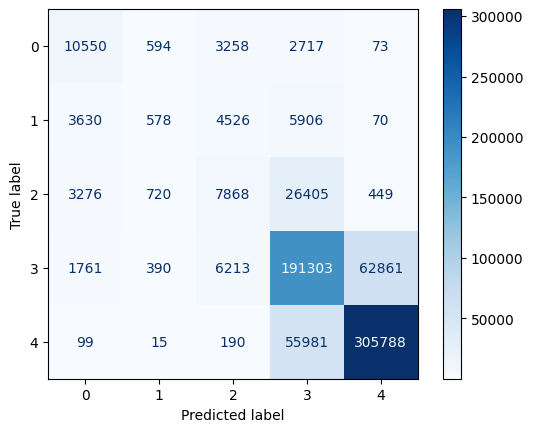

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_predicted)


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [22]:
# !pip install shap

In [24]:
import shap
# Criar o explicador SHAP
explainer = shap.TreeExplainer(model)

# Calcular os valores SHAP para os dados de teste
shap_values = explainer.shap_values(X_test_transformed)

In [ ]:
shap.summary_plot(shap_values, X_test_transformed)

In [ ]:
# Summary Plot
shap.summary_plot(shap_values[1], X_test_transformed)

In [ ]:
# Dependence Plot para uma feature específica
shap.dependence_plot(0, shap_values[1], X_test_transformed)

In [ ]:
#### com normalização
# Tempo de treinamento: 295.15193915367126
# Accuracy médio na validação cruzada: 0.7431967675274481
# Accuracy no conjunto de teste: 0.7423351711182488
# F1 Score no conjunto de teste: 0.7308591881595554
# Precision no conjunto de teste: 0.7258877933685033